In [64]:
import os

import numpy as np
import importlib
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from sklearn.decomposition import PCA


import gym_env
import utils
from utils import create_mapping, get_transition_matrix, create_mapping_nb, get_full_maze_values

## Helper Functions

In [105]:
def update_terminal_reward(agent, loc, r):
    """
    Update the reward for the terminal state of the agent according to loc

    Args:
    agent (LinearRL class) : The LinearRL agent
    loc (int) : The terminal location to change the reward of [0->n] n= number of terminal locations - 1
    r (float) : The new reward to change r[loc] to
    """
    # Get location of reward and change
    r_loc = np.argwhere(agent.terminals)[loc]
    agent.r[r_loc] = r
    # Update expr_t inside of the agent
    agent.expr_t = np.exp(agent.r[agent.terminals] / agent._lambda)

def policy_reval(agent):
    """
    The New environment is the same as the old one except we 
    
    Args:
    agent (LinearRL class) : The LinearRL agent
    r_new (array) : Updated reward

    Returns:
    V_new (array) : New value of each state
    """
    r_new = agent.r
    expr_new = np.exp(r_new[agent.terminals] / agent._lambda)
    Z_new = np.zeros(len(r_new))

    Z_new[~agent.terminals] = agent.DR[~agent.terminals][:,~agent.terminals] @ agent.P @ expr_new
    Z_new[agent.terminals] = expr_new
    V_new = np.round(np.log(Z_new), 3)

    return V_new

def decision_policy(agent):
    """
    Performs matrix version of equation 6 from the LinearRL paper

    Args:
    agent (LinearRL class) : The LinearRL agent

    Returns:
    pii (array) : The decision policy
    """
    G = np.dot(agent.T, agent.Z)

    expv_tiled = np.tile(agent.Z, (len(agent.Z), 1))
    G = G.reshape(-1, 1)
    
    zg = expv_tiled / G
    pii = agent.T * zg

    return pii

def plot_decision_prob(probs_train, probs_test):
    """
    Plots the decision probability of going towards a terminal state

    Args:
    probs_train (array) : Probability of heading towards each terminal state before policy revaluation
    probs_test (array) : probability of heading towrads each terminal state after policy revaluation
    """
    color_palette = sns.color_palette("colorblind")
    colors = [color_palette[3], color_palette[2]]
    print(colors)
    bar_positions_training = np.arange(len(probs_train)) * 0.4
    bar_positions_test = np.arange(len(probs_train)) * 0.4 + 1
    # bar_positions_training = np.array([0, 0.4])  # Bar positions for training (s1 and s2)
    # bar_positions_test = np.array([1, 1.4])  # Bar positions for test (s1 and s2)

    plt.bar(bar_positions_training, probs_train, width=0.3, color=colors, edgecolor='black')
    plt.bar(bar_positions_test, probs_test, width=0.3, color=colors, edgecolor='black')

    handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black') for i in range(len(probs_train))]
    plt.legend(handles, [f'State {i+1}' for i in range(len(probs_train))], title='States', loc='upper center')
    
    plt.ylabel('Probabilities')
    plt.xticks([0.2, 1.2], ['Training', 'Test'])
    plt.rcParams['font.family'] = 'serif'

    plt.show()

In [212]:
color_palette = sns.color_palette("colorblind")
colors = [color_palette[3], color_palette[2]]
print(colors)

[(0.8352941176470589, 0.3686274509803922, 0.0), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]


In [214]:
def rgb_to_keynote(rgb):
    return tuple(int(255 * val) for val in rgb)

# Your RGB colors
colors_rgb = [(0.8352941176470589, 0.3686274509803922, 0.0), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

# Convert to Keynote RGB sliders format
colors_keynote_rgb = [rgb_to_keynote(rgb) for rgb in colors_rgb]

print("Converted colors (Keynote RGB sliders format):", colors_keynote_rgb)

Converted colors (Keynote RGB sliders format): [(213, 94, 0), (2, 158, 115)]


## LinearRL-TD Model

In [209]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, beta=1, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random", imp_samp=False):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_locs = self.env.unwrapped.target_locs
        self.maze = self.env.unwrapped.maze
        self.walls = self.env.unwrapped.get_walls()
        self.size = self.maze.size - len(self.walls)   # Size of the state space is the = size of maze - number of blocked states
        self.height, self.width = self.maze.shape

        # Create mapping and Transition matrix
        self.mapping = create_mapping_nb(self.maze, self.walls)
        self.reverse_mapping = {index: (i, j) for (i, j), index in self.mapping.items()}
        self.T = get_transition_matrix(self.env, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # Set reward
        self.reward_nt = -1   # Non-terminal state reward
        self.reward_t = -1    # Terminal state reward
        self.r = np.full(len(self.T), self.reward_nt)
        self.r[self.terminals] = self.reward_t
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)
        # Precalculate exp(r) for use with LinearRL equations
        self.expr_nt = np.exp(self.reward_nt / _lambda)

        # Params
        self.alpha = alpha
        self.beta = beta
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy
        self.imp_samp = imp_samp

        # Model
        self.DR = self.get_DR()
        # self.DR = np.full((self.size,self.size), 0.1)
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_states(self):
        """
        Returns all non-blocked states as well as a mapping of each state (i,j) -> to an index (k)
        """
        states = []
        index_mapping = {}
        index = 0
        for i in range(len(self.maze)):
            for j in range(len(self.maze[i])):
                if self.maze[i][j] in ['0', 'S', 'G']:
                    states.append((i, j))
                    index_mapping[(i, j)] = index
                    index += 1

        return states, index_mapping

    def get_DR(self):
        """
        Returns the DR initialization based on what decision policy we are using, values are filled with 0.01 if using softmax to avoid div by zero
        """
        if self.policy == "random":
            DR = np.eye(self.size)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            np.fill_diagonal(DR, 1)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = self.expr_t
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        """
        Performs importance sampling P(x'|x)/u(x'|x). P(.) is the default policy, u(.) us the decision policy
        """
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=0.5, target_loc=None):
        """
        Action selection based on our policy
        Options are: [random, softmax, egreedy, test]
        """
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / self.beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / self.beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        """
        Calculates the DR directly using matrix inversion, used for testing
        """
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent explores the maze according to its decision policy and and updates its DR as it goes
        """
        # print(f"Decision Policy: {self.policy}, Number of Iterations: {self.num_steps}, lr={self.alpha}, temperature={self.beta}, importance sampling={self.imp_samp}")
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state)
            else:
                action = self.select_action(state, self.policy)
        
            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.imp_samp:
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            target = self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * target * w
            # If we are using importance sampling
            # if self.imp_samp:
            #     self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * target * w
            # else:
            #     self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * target

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            if done:
                self.env.reset()
                continue
            
            # Update state
            state = next_state

        # Update DR at terminal state
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)


## Train Agents

In [33]:
mazes = ["simple-5x5-2", "simple-7x7-2"]
maze_name = mazes[1]

### D_inv agent

In [52]:
# Agent to be used with D_inv
agent = LinearRL(env_name=maze_name, _lambda=1.0, alpha=0.001, beta=1.0, num_steps=500000, policy="softmax", imp_samp=True)
# Make the reward for the first terminal state higher than the second to bias the DR towards that terminal state
update_terminal_reward(agent, loc=0, r=2)

D_inv = np.linalg.inv(np.diag(np.exp(-agent.r / agent._lambda)) - agent.T)

agent.DR = D_inv
agent.update_V()
maze_values = get_full_maze_values(agent)
print(maze_values)

[[ -9.6   -7.95  -6.29  -4.63  -3.26  -2.29  -2.85]
 [-11.22   -inf   -inf  -3.24  -1.6   -0.32  -1.54]
 [-12.07   -inf   -inf   -inf   0.33   2.    -0.04]
 [-10.94  -9.72   -inf   -inf   -inf  -0.05  -1.43]
 [ -9.45  -8.08  -6.28  -4.96   -inf  -2.09  -3.09]
 [ -8.05  -6.61  -4.84  -3.32  -4.42  -4.27  -4.87]
 [ -6.75  -5.11  -3.06  -1.    -3.05  -4.84  -5.86]]


In [53]:
pii_old = decision_policy(agent)
print(pii_old[0])

[0.         0.96328509 0.         0.         0.         0.
 0.         0.03671491 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [54]:
# Update the second terminal state to make it double that of the first
update_terminal_reward(agent, loc=1, r=8)
V_new = policy_reval(agent=agent)

In [55]:
agent.V = V_new
maze_values = get_full_maze_values(agent)
print(maze_values)

[[-6.863 -7.525 -6.272 -4.633 -3.259 -2.292 -2.843]
 [-5.27    -inf   -inf -3.244 -1.597 -0.318 -1.534]
 [-3.615   -inf   -inf   -inf  0.334  2.    -0.027]
 [-1.958 -0.723   -inf   -inf   -inf  0.153 -1.089]
 [-0.447  0.915  2.717  4.038   -inf  0.576 -0.502]
 [ 0.947  2.387  4.163  5.68   4.435  2.545  1.036]
 [ 2.25   3.892  5.939  8.     5.945  3.904  2.266]]


In [56]:
agent.update_V()
pii_new = decision_policy(agent)

In [57]:
print(pii_new[0])

[0.         0.09495049 0.         0.         0.         0.
 0.         0.90504951 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


[(0.8352941176470589, 0.3686274509803922, 0.0), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]


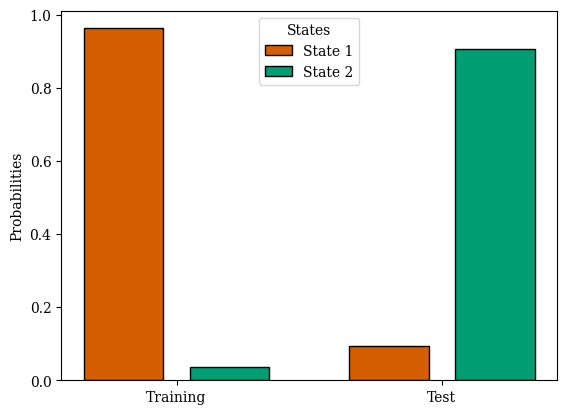

In [108]:
plot_decision_prob(probs_train=[0.963, 0.0367], probs_test=[0.09495049, 0.90504951])

### Agent with importance sampling

In [164]:
# Initialize the agent
agent_with_imp = LinearRL(env_name="simple-7x7-2", _lambda=1, alpha=0.01, beta=1, num_steps=50000, policy="softmax", imp_samp=True)
update_terminal_reward(agent_with_imp, loc=0, r=4)


In [165]:
# Train the agent with importance sampling
agent_with_imp.learn()

Decision Policy: softmax, Number of Iterations: 50000, lr=0.01, temperature=1, importance sampling=True


In [166]:
# Print out the values to see what it learned
maze_values = get_full_maze_values(agent_with_imp)
print(maze_values)

[[-6.48 -4.93 -3.28 -1.63 -0.26  0.73  0.08]
 [-6.84  -inf  -inf -0.25  1.37  2.7   1.48]
 [-6.05  -inf  -inf  -inf  3.34  4.    3.01]
 [-5.12 -4.26  -inf  -inf  -inf  2.99  1.59]
 [-4.24 -3.92 -2.8  -1.96  -inf  0.95 -0.15]
 [-3.59 -3.32 -2.46 -1.39 -0.96 -0.59 -0.39]
 [-2.94 -2.74 -1.28 -1.   -0.45 -0.54 -0.4 ]]


In [167]:
update_terminal_reward(agent_with_imp, loc=1, r=8)
V_new = policy_reval(agent=agent_with_imp)

In [168]:
agent_with_imp.V = V_new
maze_values = get_full_maze_values(agent_with_imp)
print(maze_values)

[[-4.787 -4.433 -2.975 -1.362  0.051  1.239  1.913]
 [-3.323   -inf   -inf -0.063  1.541  2.907  1.737]
 [-2.144   -inf   -inf   -inf  3.504  4.     3.204]
 [-0.837  0.315   -inf   -inf   -inf  3.211  1.886]
 [ 0.549  1.831  3.593  4.862   -inf  2.09   2.761]
 [ 1.888  3.411  5.182  6.536  5.131  3.218  3.2  ]
 [ 3.195  4.935  7.109  8.     6.896  4.364  3.25 ]]


In [169]:
pii_old = decision_policy(agent_with_imp)
print(pii_old[0])

[0.         0.87063943 0.         0.         0.         0.
 0.         0.12936057 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [170]:
agent_with_imp.update_V()
pii_new = decision_policy(agent_with_imp)
pii_new[0]

array([0.        , 0.24773242, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.75226758, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

[(0.8352941176470589, 0.3686274509803922, 0.0), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]


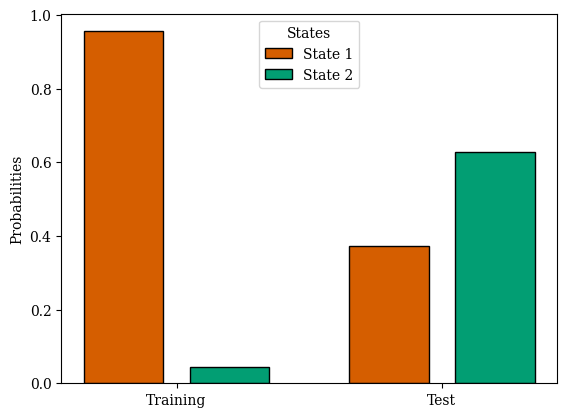

In [163]:
plot_decision_prob(probs_train=[0.95555602, 0.04444398], probs_test=[0.37327763, 0.62672237])

### Agent without importance sampling

In [199]:
agent_no_imp = LinearRL(env_name="simple-7x7-2", _lambda=1, alpha=0.01, beta=1, num_steps=300000, policy="softmax", imp_samp=False)
update_terminal_reward(agent_no_imp, loc=0, r=4)

In [200]:
# Train agent without importance sampling
agent_no_imp.learn()

Decision Policy: softmax, Number of Iterations: 300000, lr=0.01, temperature=1, importance sampling=False


In [201]:
# Print out the values to see what it learned
maze_values = get_full_maze_values(agent_no_imp)
print(maze_values)

[[-3.33 -2.26 -1.19 -0.05  0.92  1.62  0.74]
 [-4.5   -inf  -inf  1.09  2.1   2.78  1.86]
 [-4.74  -inf  -inf  -inf  3.41  4.    3.03]
 [-4.05 -3.37  -inf  -inf  -inf  3.03  2.01]
 [-3.39 -3.17 -2.3  -1.6   -inf  1.82  0.89]
 [-2.79 -2.68 -1.99 -1.08 -0.64  0.66 -0.33]
 [-2.22 -2.01 -1.03 -1.   -0.52 -0.6  -0.64]]


In [202]:
update_terminal_reward(agent_no_imp, loc=1, r=8)
V_new = policy_reval(agent=agent_no_imp)

In [203]:
agent_no_imp.V = V_new
maze_values = get_full_maze_values(agent_no_imp)
print(maze_values)

[[-3.284 -2.232 -1.16  -0.023  0.955  1.653  0.766]
 [-3.242   -inf   -inf  1.118  2.135  2.806  1.893]
 [-0.95    -inf   -inf   -inf  3.439  4.     3.058]
 [ 0.155  1.226   -inf   -inf   -inf  3.057  2.037]
 [ 1.254  2.587  4.039  5.196   -inf  1.878  0.96 ]
 [ 2.488  3.931  5.469  6.655  4.797  1.958  1.678]
 [ 3.777  5.451  6.932  8.     6.922  4.269  3.049]]


In [204]:
pii_old = decision_policy(agent_no_imp)
print(pii_old[0])

[0.         0.90335744 0.         0.         0.         0.
 0.         0.09664256 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [205]:
agent_no_imp.update_V()
pii_new = decision_policy(agent_no_imp)
pii_new[0]

array([0.        , 0.73302041, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.26697959, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

[(0.8352941176470589, 0.3686274509803922, 0.0), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]


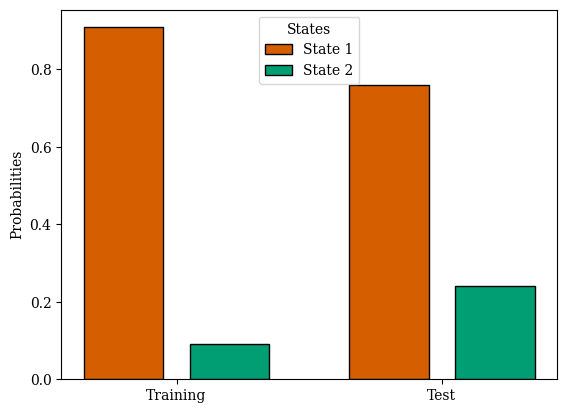

In [110]:
plot_decision_prob(probs_train=[0.90834118 , 0.09165882], probs_test=[0.75925148, 0.24074852])

In [206]:
agent_no_imp.DR.shape

(40, 40)

### Averages

In [210]:
num_iterations = 100

DR_avg_with_imp = np.zeros((40, 40))
DR_avg_no_imp = np.zeros((40,40))
# Construct a T for SR that prefers going to the right

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL(env_name="simple-7x7-2", _lambda=1, alpha=0.01, beta=1, num_steps=400000, policy="softmax", imp_samp=True)
    update_terminal_reward(agent_with_imp, loc=0, r=4)
    agent_no_imp = LinearRL(env_name="simple-7x7-2", _lambda=1, alpha=0.01, beta=1, num_steps=400000, policy="softmax", imp_samp=False)
    update_terminal_reward(agent_no_imp, loc=0, r=4)

    # Have the agents learn the environment
    agent_no_imp.learn()
    agent_with_imp.learn()

    # Add
    DR_avg_with_imp += agent_with_imp.DR
    DR_avg_no_imp += agent_no_imp.DR

# Take average
DR_avg_with_imp /= num_iterations
DR_avg_no_imp /= num_iterations

KeyboardInterrupt: 